In [1]:
%reload_ext autoreload
%autoreload 2

from tempfile import TemporaryDirectory
from pathlib import Path
from torch import nn
import torch as tr

from nwgraph.graph.node import DimNode
from nwgraph.graph import BipartiteGraph
from nwgraph.layers import PathwayListMp
from nwgraph.pathway import Pathway as P, PathwayList as PL, ConvergingPathways as CP

## Pathways Message Passing

We'll extend the pathways notebook example to message passing. We'll start with some forward passing.

[2025-01-17T18:10:37 NWGRAPH-INFO] Built 2 path models for Layer: 'PathwayListMp' (paths: 2, path edges: 2, n_steps: 1, memory: False) on G: BipartiteGraph (N:3, A:2 B:1, E:2, NS: 0 [None]. (pathway_list_mp.py:_build_pathway_list_models:236)


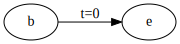

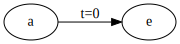

[2025-01-17T18:10:37 NWGRAPH-DEBUG] Message passing for t=1 finished (pathway_list_mp.py:message_pass:75)


Graph:
- Type: BipartiteGraph
- Nodes (3): [a (3,), b (3,), e (3,)]
- Edges (2): Edge(a (3,)->e (3,)), Edge(b (3,)->e (3,))
- States set: 3
- Nodes type a (2): [a (3,), b (3,)]
- Nodes type b (1): [e (3,)]


In [2]:
edge_indexes = [("a", "e"), ("b", "e")]
graph = BipartiteGraph(edge_indexes, nodes_type_a=["a", "b"], node_types=DimNode,
                       node_args={"dims": (3, )}, node_names=["a", "b", "e"])
pathways = PL([P(["a", "e"]), P(["b", "e"])])
mp_layer = PathwayListMp(graph, nn.Linear, "mean", pathways)

# plot all the partial pathways
for pathway in mp_layer.pathways.partial_pathways:
    if len(pathway) > 1:
        display(pathway.to_graphviz())
x = {"a": tr.randn(3, ), "b": tr.rand(3, )}
g_y = mp_layer(x)
print(g_y)

We can also see all paths that are considered inside a PathwayListMp. We'll use a more difficult example this time.

[2025-01-17T18:10:37 NWGRAPH-INFO] Built 3 path models for Layer: 'PathwayListMp' (paths: 3, path edges: 9, n_steps: 3, memory: False) on G: BipartiteGraph (N:8, A:2 B:6, E:7, NS: 0 [None]. (pathway_list_mp.py:_build_pathway_list_models:236)


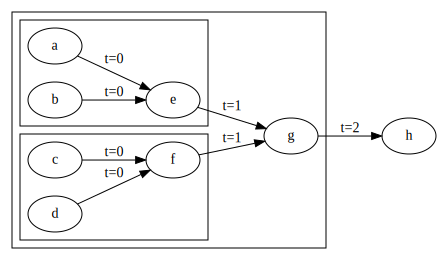

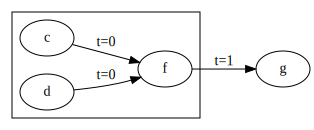

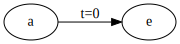

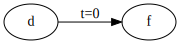

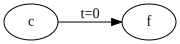

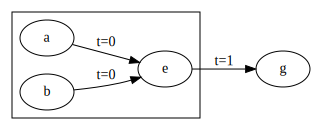

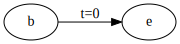

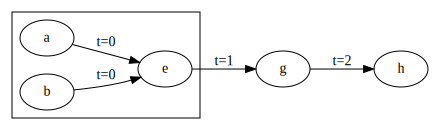

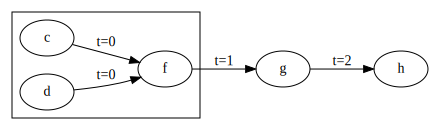

In [3]:
# taken from test_pathway_list_mp.py::test_PathwayListMp_pathway_merging_model_5
edge_indexes = [("a", "e"), ("b", "e"), ("c", "f"), ("d", "f"), ("e", "g"), ("f", "g"), ("g", "h")]
dims = {"a": (2, ), "b": (4, ), "c": (6, ), "d": (8, ), "e": (10, ), "f": (12, ), "g": (14, ), "h": (16, )}
graph = BipartiteGraph(edge_indexes, nodes_type_a=["a", "b"], node_types=DimNode,
                        node_args=[{"dims": dims[node_name]} for node_name in dims],
                        node_names=["a", "b", "c", "d", "e", "f", "g", "h"])
pathways = PL([
    P([
        CP([
            P([CP([P(["a", "e"]), P(["b", "e"])]), "g"]),
            P([CP([P(["c", "f"]), P(["d", "f"])]), "g"])
        ]), "h"
    ]),
    P([CP([P(["a", "e"]), P(["b", "e"])]), "g", "h"]),
    P([CP([P(["c", "f"]), P(["d", "f"])]), "g", "h"]),
])

mp_layer = PathwayListMp(graph, nn.Linear, "mean", pathways)
for pathway in mp_layer.pathways.partial_pathways:
    if len(pathway) > 1:
        display(pathway.to_graphviz())